In [ ]:
%pip install -r requirements.txt

In [4]:
import os
import re
import shutil
import requests
import numpy as np
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
from typing import List, Dict, Union

In [ ]:
# shutil.rmtree('text')
# shutil.rmtree('processed')

Crawl zuddl knowledge base and text preprocessing

In [5]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "help.zuddl.com"
full_url = "https://help.zuddl.com/support/home"

Page = Dict[str, Union[str, Dict[str, str]]]
PAGES: List[Page] = []

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self) -> None:
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs) -> None:
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url: str) -> List[str]:
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain: str, url: str) -> List[str]:
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [6]:
def truncate_string(text: str) -> str:
    end_index = text.find("Was this article helpful?")
    start_index = text.find("Sorry! nothing found for") + 24

    if start_index != -1 or end_index != -1:
      return text[start_index:end_index]
    if start_index != -1:
      return text[:end_index]
    if end_index != -1:
      return text[start_index:]
    
    return text

def remove_newlines(text: str) -> str:
    text = text.replace('\n', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('  ', ' ')
    text = text.replace('  ', ' ')
    return text

def process_text(text: str) -> str:
  text = remove_newlines(text)
  text = truncate_string(text)
  return text.strip()

In [7]:
def crawl(url: str) -> None:
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            processed_text = process_text(text)

            if soup.title:
                title = str(soup.title.string).strip()
            else:
                title = ""
            
            print(f"{title} - {url}")

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(processed_text)
            
            PAGES.append({
              'content': processed_text + '\n\n',
              'metadata': {
                'title': title,
                'url': url
              }
            })

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [8]:
crawl(full_url)

Support : zuddl - https://help.zuddl.com/support/home
Customize Booths : zuddl - https://help.zuddl.com/support/solutions/articles/84000374594-customize-booths
Support : zuddl - https://help.zuddl.com
Set up Branding for your Event : zuddl - https://help.zuddl.com/support/solutions/articles/84000372923-set-up-branding-for-your-event
Choose a Theme : zuddl - https://help.zuddl.com/support/solutions/articles/84000353343-choose-a-theme
Choose a Brand Color : zuddl - https://help.zuddl.com/support/solutions/articles/84000353344-choose-a-brand-color
Apply Branding to your Registration Page : zuddl - https://help.zuddl.com/support/solutions/articles/84000374535-apply-branding-to-your-registration-page
Customize Registration Fields : zuddl - https://help.zuddl.com/support/solutions/articles/84000374536-customize-registration-fields
Conditional Registration : zuddl - https://help.zuddl.com/support/solutions/articles/84000379176-conditional-registration
Communication : zuddl - https://help.zudd

Sample Metadata output

In [9]:
print(PAGES[200]['metadata'])

{'title': 'Edit Registration Form : zuddl', 'url': 'https://help.zuddl.com/support/solutions/articles/84000375716-edit-registration-form'}


Using tiktoken to estimate the total number of tokens

<Axes: >

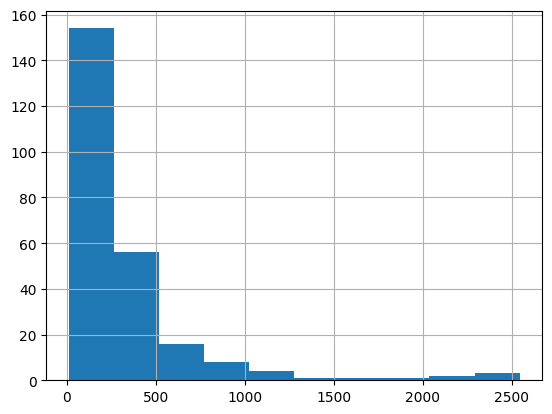

In [10]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

data_modified = [
    {
        'title': d['metadata']['title'],
        'url': d['metadata']['url'],
        'content': d['content']
    }
    for d in PAGES
]

# Create DataFrame
df_tokens = pd.DataFrame(data_modified)

# Tokenize the text and save the number of tokens to a new column
df_tokens['n_tokens'] = df_tokens.content.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df_tokens.n_tokens.hist()

In [11]:
df_tokens

,title,url,content,n_tokens
0,Support : zuddl,https://help.zuddl.com/support/home,Browse articles Explore How-To's and learn bes...,112
1,Customize Booths : zuddl,https://help.zuddl.com/support/solutions/artic...,"Customize Booths Modified on Wed, 09 Nov 2022...",776
2,Support : zuddl,https://help.zuddl.com,Browse articles Explore How-To's and learn bes...,112
3,Set up Branding for your Event : zuddl,https://help.zuddl.com/support/solutions/artic...,Set up Branding for your Event Modified on Fr...,496
4,Choose a Theme : zuddl,https://help.zuddl.com/support/solutions/artic...,"Choose a Theme Modified on Fri, 06 May 2022 a...",158
...,...,...,...,...
241,Events (New) - Guide : zuddl,https://help.zuddl.com/support/solutions/84000...,Events (New) - Guide (18) Learn everything abo...,274
242,Domains and Ports Whitelisting : zuddl,https://help.zuddl.com/support/solutions/artic...,"Domain and Port Whitelisting Modified on Mon,...",315
243,Sign into : zuddl,https://help.zuddl.com/support/search/tickets,Skip to main content zuddl Home Knowle...,135
244,Search : zuddl,https://help.zuddl.com/support/search/solutions,"Search results for """" Search results for """" A...",18


Splitting the text into smaller chunks for efficiency

In [12]:
from langchain.text_splitter import TokenTextSplitter

chunk_type = Dict[str, Union[str, int, List]]

def chunk_data() -> List[chunk_type]:
    text_splitter = TokenTextSplitter(encoding_name="cl100k_base", chunk_size=500, chunk_overlap=100)

    chunks = []

    for page in PAGES:
        splits = text_splitter.split_text(page['content'])

        for split in splits:
          chunks.append({
              "article_title": page['metadata']['title'],
              "article_url": page['metadata']['url'],
              "content": split,
              "content_length": len(split),
              "content_tokens": len(tokenizer.encode(split)),
              "embedding": []
          })
        print(f"Splitted {page['metadata']['url']} into {len(splits)} chunks.")

    print(f'Total chunks created: {len(chunks)}.\n')
    return chunks

In [13]:
chunks = chunk_data()

Splitted https://help.zuddl.com/support/home into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000374594-customize-booths into 2 chunks.
Splitted https://help.zuddl.com into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000372923-set-up-branding-for-your-event into 2 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000353343-choose-a-theme into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000353344-choose-a-brand-color into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000374535-apply-branding-to-your-registration-page into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000374536-customize-registration-fields into 1 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000379176-conditional-registration into 2 chunks.
Splitted https://help.zuddl.com/support/solutions/articles/84000374653-communication into 3 chunks.
Splitted ht

Sample chunked object

In [14]:
import json
print(json.dumps(chunks[7], sort_keys=True, indent=4))

{
    "article_title": "Choose a Brand Color : zuddl",
    "article_url": "https://help.zuddl.com/support/solutions/articles/84000353344-choose-a-brand-color",
    "content": "Choose a Brand Color  Modified on Fri, 06 May 2022 at 06:10 AM    One of the many elements consumers use to associate with any brand is brand color. Zuddl Studio lets you choose your brand color which is applied to banners and background images and aims to improve your brand-color association. To select your brand color:Scroll to the Brand Colour section.Click on the color picker box and select a color using the slider or choose one from the preset list. Defaults to #0080FF.Tip: If you have the color hex code handy, paste it directly inside the text field. Generate your brand color hex-code.\n\n",
    "content_length": 600,
    "content_tokens": 131,
    "embedding": []
}


Distribution for number of tokens in the chunks dataframe

<Axes: >

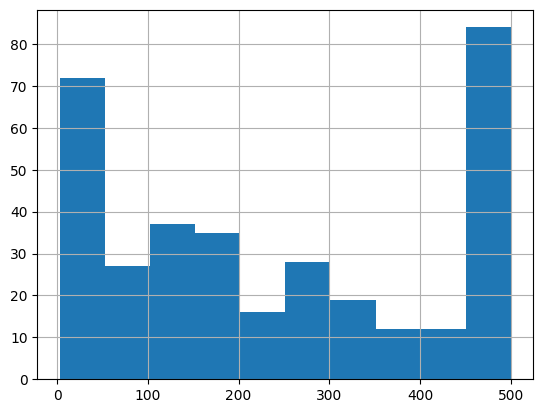

In [15]:
df_chunked = pd.DataFrame(chunks)

# Visualize the distribution of the number of tokens per row using a histogram
df_chunked.content_tokens.hist()

In [16]:
df_chunked

,article_title,article_url,content,content_length,content_tokens,embedding
0,Support : zuddl,https://help.zuddl.com/support/home,Browse articles Explore How-To's and learn bes...,564,112,[]
1,Customize Booths : zuddl,https://help.zuddl.com/support/solutions/artic...,"Customize Booths Modified on Wed, 09 Nov 2022...",2254,500,[]
2,Customize Booths : zuddl,https://help.zuddl.com/support/solutions/artic...,: Allow visitors to chat publicly with other v...,1803,376,[]
3,Support : zuddl,https://help.zuddl.com,Browse articles Explore How-To's and learn bes...,564,112,[]
4,Set up Branding for your Event : zuddl,https://help.zuddl.com/support/solutions/artic...,Set up Branding for your Event Modified on Fr...,2361,496,[]
...,...,...,...,...,...,...
337,Events (New) - Guide : zuddl,https://help.zuddl.com/support/solutions/84000...,Events (New) - Guide (18) Learn everything abo...,1172,274,[]
338,Domains and Ports Whitelisting : zuddl,https://help.zuddl.com/support/solutions/artic...,"Domain and Port Whitelisting Modified on Mon,...",1375,315,[]
339,Sign into : zuddl,https://help.zuddl.com/support/search/tickets,Skip to main content zuddl Home Knowle...,613,135,[]
340,Search : zuddl,https://help.zuddl.com/support/search/solutions,"Search results for """" Search results for """" A...",84,18,[]


Saving the dataframe as CSV and JSON

In [17]:
df_chunked.to_csv('processed/chunks.csv', index=True)
df_chunked.to_json('processed/chunks.json', orient='records', index=True)

Total number of tokens generated

In [ ]:
df_chunked['content_tokens'].sum()

Generating embeddings using OpenAI embeddings API

In [19]:
import openai

openai.api_key = os.environ.get('OPENAI_API_KEY')

def create_embedding(text: str):
    response = openai.Embedding.create(
        input = text,
        model = 'text-embedding-ada-002'
    )

    print(f"response: {response}")

    embedding = response['data'][0]['embedding']
    
    print(f"embedding: {embedding}")

    with open('processed/embeds.txt', 'a') as f1:
        f1.write(str(embedding) + '\n\n')

    with open('processed/response.txt', 'a') as f0:
        f0.write(text + '\n' + str(response) + '\n\n\n')

    return embedding

In [ ]:
for i, row in df_chunked.iterrows():
  print(f"Processing row {i} of {len(df_chunked)}")
  
  embedding = create_embedding(row["content"])

  if embedding:
    df_chunked.at[i, "embedding"] = embedding

In [ ]:
df_chunked

Saving the dataframe as CSV and JSON

In [ ]:
df_chunked.to_csv('processed/chunks_with_embeds.csv', index=True)
df_chunked.to_json('processed/chunks_with_embeds.json', orient='records', index=True)

Saving the dataframe to postgres database

In [ ]:
from supabase import create_client, Client

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [ ]:
def insert_articles(row) -> None:
		
		data, count = supabase.table('articles').insert({
			"article_title": row["article_title"],
			"article_url": row["article_url"],
			"content_length": row["content_length"],
			"content_tokens": row["content_tokens"],
			"content": row["content"],
			"embedding": row["embedding"],
			}).execute()
		
		print(f"API response: {data}, {count}\n")

In [ ]:
for i, row in df_chunked.iterrows():
	print(f"Inserting row {i} of {len(df_chunked)}")
	insert_articles(row)